In [ ]:
%load_ext autoreload
%autoreload 2

In [21]:
import sys

if '..' not in sys.path:
    sys.path.insert(0, '..')

import glm
import r_plotter
from pandas import DataFrame
from numpy import ndarray
import pandas as pd
import numpy as np
from typing import Dict, Tuple, List
import plotly.express as px

import time
import warnings

import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

# Clustering

In [31]:
n_samples = 1500
blobs = pd.DataFrame(datasets.make_blobs(n_samples=n_samples, random_state=8)[0])
px.scatter(x=blobs[0], y=blobs[1])

In [30]:
blobs[0]

0       5.867498
1       5.613700
2       7.225084
3       6.762823
4       8.016182
          ...   
1495    5.845618
1496   -4.546978
1497    7.736741
1498   -4.617011
1499   -3.486402
Name: 0, Length: 1500, dtype: float64

# Using R in Notebook

## R Function Import

In [3]:
from rpy2 import robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.vectors import DataFrame as r_DataFrame

#RESOURCES
# 1. https://stackoverflow.com/questions/11238472/how-to-get-rid-code-when-printing-summary-in-rpy2

# 2. how to sub-select columns in R
# mtcars[, -which(names(mtcars) == "carb")]  #only works on a single column
# mtcars[, names(mtcars) != "carb"]          #only works on a single column
# mtcars[, !names(mtcars) %in% c("carb", "mpg")] 
# mtcars[, -match(c("carb", "mpg"), names(mtcars))] 
# mtcars2 <- mtcars; mtcars2$hp <- NULL         #lost column (risky)

# 3. https://www.learnbymarketing.com/tutorials/explaining-the-lm-summary-in-r/

## Passing Data Between Python and R

In [4]:
# R libraries
r_arrow = importr('arrow')
r_mass = importr('MASS')
r_base = importr('base')
r_stats = importr('stats')
r_graphics = importr('graphics')
r_devices = importr('grDevices')
r_datasets = importr('datasets')

# R itself
r = ro.r

# R functions
r_lm = r['lm']
r_predict = r['predict']
r_summary = r['summary']
r_fitted = r['fitted']
r_resid = r['resid']
r_plot = r['plot']
r_png = r['png']
r_qqnorm = r['qqnorm']
r_lm_influence = r['lm.influence']
r_loess_smooth = r['loess.smooth']
r_print = ro.globalenv.find('print')


In [5]:
#create dataframe
r_df = r_arrow.read_parquet('data.parquet')

#create R formula
target = 'y'
predictors = r_df.colnames[:-1]
linear_predictor = '+'.join(predictors)
formula = ro.Formula(f'{target} ~ 0 + {linear_predictor}')

for i, name in enumerate(list(predictors) + [target]):
    formula.environment[name] = r_df[i] #integer index accesses the column vectors

# fit a linear model
model = r_stats.lm(formula=formula)

summary = r_summary(model)

In [10]:
print('Adj. R Sq. = ', summary[8])
print(summary[3])
print('\n')

Adj. R Sq. =  [1] 0.9999507

             Estimate   Std. Error       t value   Pr(>|t|)
feat_1   0.0002258395 0.0005778814  3.908061e-01 0.69594061
feat_2  60.3744813394 0.0005775658  1.045326e+05 0.00000000
feat_3  75.9496703801 0.0005775789  1.314966e+05 0.00000000
feat_4  43.0696566993 0.0005773248  7.460213e+04 0.00000000
feat_5  -0.0011182604 0.0005775545 -1.936199e+00 0.05284345
feat_6  37.2652763754 0.0005777336  6.450252e+04 0.00000000
feat_7   0.0005786779 0.0005777240  1.001651e+00 0.31651220
feat_8  87.4437594014 0.0005772971  1.514710e+05 0.00000000
feat_9  -0.0011803943 0.0005774474 -2.044159e+00 0.04093794
feat_10  0.0004765941 0.0005774029  8.254099e-01 0.40913898





In [16]:
m = r.matrix(r.rnorm(100), ncol=5)
pca = r.princomp(m)
# r.plot(pca, main="Eigen values")
# r.biplot(pca, main="biplot")

In [30]:
print(m)

             [,1]        [,2]        [,3]        [,4]        [,5]
 [1,]  2.70057750  0.26450102  0.15475864 -0.34009907  1.31276160
 [2,]  0.49482854 -0.83880356  0.19004509  0.57307243  0.07449749
 [3,]  0.61342378 -0.17304290 -0.08409200 -1.42866916  0.95685328
 [4,] -1.41197129  1.21768758 -0.81115482 -0.68309614 -1.68125275
 [5,]  0.81396945 -0.19936456 -0.50241929  0.86576992 -0.93929704
 [6,] -0.25331940  1.30101429 -0.29435358 -1.92432165 -1.51522625
 [7,]  1.43622823 -0.03542858  0.16906780 -0.03569574 -0.10735430
 [8,] -0.45143615  0.25164664  1.89058481 -1.28484405 -1.37491968
 [9,]  1.82201473 -1.43124712 -0.62528937 -1.22329394 -0.73337328
[10,]  1.17739388 -0.69125743 -2.04248615  0.38181092 -1.15420285
[11,]  0.90535970  0.82328260  0.01914288  0.58768713 -2.05071048
[12,] -0.60510202 -0.63545679  1.08372917 -0.03701257 -1.83789019
[13,]  0.08807087  1.41437799 -2.27614719  0.16137195  1.16577449
[14,]  0.97415925 -0.91920477  1.27178526  1.13917420  0.69666229
[15,] -1.0

In [49]:
pca

sdev,[RTYPES.REALSXP]
loadings,[RTYPES.REALSXP]
center,[RTYPES.REALSXP]
scale,[RTYPES.REALSXP]
n.obs,[RTYPES.INTSXP]
scores,[RTYPES.REALSXP]
call,[RTYPES.LANGSXP]


In [48]:
print(pca.rx2['loadings'])


Loadings:
     Comp.1 Comp.2 Comp.3 Comp.4 Comp.5
[1,]  0.490  0.274  0.420  0.472  0.534
[2,]        -0.581 -0.309 -0.227  0.718
[3,] -0.417  0.715 -0.379         0.401
[4,]  0.171  0.191  0.487 -0.829       
[5,]  0.745  0.197 -0.589 -0.167 -0.174

               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5
SS loadings       1.0    1.0    1.0    1.0    1.0
Proportion Var    0.2    0.2    0.2    0.2    0.2
Cumulative Var    0.2    0.4    0.6    0.8    1.0



In [25]:
pca.rx2['scores']

2.052282,0.160184,0.665889,...,-1.064673,0.396990,0.315736


In [7]:
def r_assign(**kwargs) -> None:
    for arg, val in kwargs.items():
        robjects.r.assign(arg, val)
    
    return None

r_assign(x=robjects.vectors.FloatVector([1.0,2.0,3.0]))

In [13]:
r_graphics.plot_default(r['x'])

<rpy2.rinterface_lib.sexp.NULLType object at 0x7fefb9602ac0> [RTYPES.NILSXP]

In [6]:
#values for residual diagnostics
fitted = r_fitted(model)

residuals = r_resid(model)

standardized_residuals = r_mass.stdres(model)

qqnorm = r(r'''
    function(x) {
        qqnorm(x, plot.it = F)$x
    }
''')
residuals_quantiles = qqnorm(residuals)

leverage = r_lm_influence(model).rx2('hat')

loess_1 = r_loess_smooth(fitted, residuals)
# loess_2 = loess.smooth(Fitted.Values, Root.Residuals)
# loess_3 = loess.smooth(Leverage, Residuals)

In [8]:
r_print(residuals)

            1             2             3             4             5 
-3.761031e-01 -1.671704e+00 -6.712577e-03  3.966865e-01 -1.824553e-01 
            6             7             8             9            10 
-9.110048e-01 -8.899104e-01 -5.027756e-01 -2.921285e+00  1.668891e-01 
           11            12            13            14            15 
 1.369114e-01  9.022338e-01  2.688553e-01  2.129480e-01 -2.118908e-01 
           16            17            18            19            20 
 1.514338e+00 -1.909648e-01  1.248979e+00  2.054141e-01 -7.394540e-01 
           21            22            23            24            25 
-7.976052e-01  3.761312e-01 -2.847395e-02  1.360399e-01 -1.449909e+00 
           26            27            28            29            30 
 1.756737e+00  5.122504e-01 -4.132095e-01  8.026995e-01 -4.461182e-01 
           31            32            33            34            35 
-1.774356e-01 -5.586432e-01 -1.029808e+00 -2.380504e-01  6.343655e-01 
      

In [9]:
def r_assign(**kwargs) -> None:
    for arg, val in kwargs.items():
        robjects.r.assign(arg, val)
    
    return None

r_assign(model=model)

In [11]:
#plot feat_1
hist = r['hist']
r['png']('./hist.png', width=500, height=500)
hist(r_df[1], main="", xlab="", br=20)
r['dev.off']()

1


In [8]:
print('R model Object')
print(r_model.names)
print('Coefficients')
r_model.rx2('coefficients')

# for i, name in enumerate([target] + predictors):
#     formula.environment[name] = r_df[i+1] #integer index accesses the column vectors

R model Object
 [1] "coefficients"  "residuals"     "effects"       "rank"         
 [5] "fitted.values" "assign"        "qr"            "df.residual"  
 [9] "xlevels"       "call"          "terms"         "model"        

Coefficients


76.891327,64.095866,28.466851,...,78.898106,88.582059,67.101503


In [9]:
def r_assign(**kwargs) -> None:
    for arg, val in kwargs.items():
        robjects.r.assign(arg, val)
    
    return None

r_assign(model=r_model)
# %R summary(r_model) #does not work and I do not know why

In [10]:
model = r['model']
# summary = r['summary']
predict = r['predict']

predict(model)

512.828440,-48.809201,91.920286,...,97.358337,78.950054,241.594966


In [9]:
%%R
library(arrow)

df = arrow::read_parquet('data.parquet')
predictors = names(df[, names(df) != 'y'])
formula = paste('y~', paste(predictors, collapse='+'))
model = lm(formula, df)

summary(model)


Call:
lm(formula = formula, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.1286 -0.6741 -0.0004  0.6742  5.1757 

Coefficients:
              Estimate Std. Error    t value Pr(>|t|)    
(Intercept) -0.0006497  0.0005775     -1.125   0.2606    
feat_1       0.0002263  0.0005779      0.392   0.6954    
feat_2      60.3744811  0.0005776 104532.633   <2e-16 ***
feat_3      75.9496707  0.0005776 131496.615   <2e-16 ***
feat_4      43.0696569  0.0005773  74602.130   <2e-16 ***
feat_5      -0.0011181  0.0005776     -1.936   0.0529 .  
feat_6      37.2652766  0.0005777  64502.519   <2e-16 ***
feat_7       0.0005785  0.0005777      1.001   0.3167    
feat_8      87.4437596  0.0005773 151470.992   <2e-16 ***
feat_9      -0.0011794  0.0005774     -2.042   0.0411 *  
feat_10      0.0004770  0.0005774      0.826   0.4087    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1 on 2999989 degrees of freedom
Multiple R-squared:      1,	Ad

In [10]:
%%R -w 800 -h 600

plot(model)

In [99]:
robjects.r.assign('val', val)
robjects.r.assign('exp', exp)
robjects.r.assign('tiempo', tiempo)
robjects.r('anova <- aov(val ~ tiempo + exp)')
robjects.r('s.anova <- summary(anova)')
robjects.r('spHoc <- summary(glht(anova, linfct=mcp(tiempo="Dunnet")))')
print robjects.r('s.anova')
print ro.r('spHoc')
ro.r('capture.output(s.anova, file = "anova.txt", append = TRUE)')
ro.r('capture.output(spHoc, file = "anova.txt", append = TRUE)')


In [14]:
def r_assign(**kwargs) -> None:
    for arg, val in kwargs.items():
        robjects.r.assign(arg, val)
    
    return None

%R library(arrow)
%R r_df = arrow::read_parquet('data.parquet')

columns = pd.read_parquet('data.parquet').columns
target = columns[-1]
predictors = columns[:-1].values
linear_predictor = '+'.join(predictors)
formula = f'{target} ~ 0 + {linear_predictor}'

print(formula)
# robjects.r('model = lm(formula)')
# robjects.r('s.anova <- summary(anova)')

y ~ 0 + feat_1+feat_2+feat_3+feat_4+feat_5+feat_6+feat_7+feat_8+feat_9+feat_10


In [18]:
r_assign(predictors=predictors)

NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'numpy.ndarray'>'

In [16]:
r_assign(target=target, predictors=predictors, formula=formula)

NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'numpy.ndarray'>'

In [1]:
import math, datetime
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.ipython.ggplot import image_png

base = importr('base')

mtcars = data(datasets).fetch('mtcars')['mtcars']

rnorm = stats.rnorm
dataf_rnorm = \
    robjects.DataFrame({
        'value': rnorm(300, mean=0) + rnorm(100, mean=3),
        'other_value': rnorm(300, mean=0) + rnorm(100, mean=3),
        'mean': IntVector([0, ]*300 + [3, ] * 100)})
gp = ggplot2.ggplot(mtcars)

pp = (gp +
      ggplot2.aes_string(x='wt', y='mpg') +
      ggplot2.geom_point())

image_png(pp)

NameError: name 'data' is not defined

In [106]:
dataf = r_utils.read_csv('https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/'
                       'master/notebooks/data/california_cities.csv')

import rpy2.ipython.html
rpy2.ipython.html.init_printing()

dataf

,,X,city,latd,longd,...,area_water_km2,area_water_percent
0,1,0,Adelanto,34.57611111111112,-117.43277777777779,...,0.046,0.03
1,2,1,AgouraHills,34.15333333333333,-118.76166666666667,...,0.076,0.37
2,3,2,Alameda,37.75611111111111,-122.27444444444444,...,31.983,53.79
3,4,3,Albany,37.886944444444445,-122.29777777777778,...,9.524,67.28
4,5,4,Alhambra,34.081944444444446,-118.135,...,0.003,0.01
5,6,5,AlisoViejo,33.575,-117.72555555555556,...,0.0,0.0
6,7,6,Alturas,41.48722222222222,-120.5425,...,0.036000000000000004,0.57
7,8,7,AmadorCity,38.419444444444444,-120.82416666666666,...,0.0,0.0
...,...,...,...,...,...,...,...,...
480,481,480,Yucaipa,34.030277777777776,-117.04861111111111,...,0.013000000000000001,0.02


In [105]:
stats = importr('stats')
base = importr('base')
fit = stats.lm('elevation_m ~ latd + longd', data=dataf)
fit

0,coefficients,(Intercep...
1,residuals,...
2,effects,...
3,rank,[1] 3
4,fitted.values,...
5,assign,[1] 0 1 2
6,qr,$qr ...
7,df.residual,[1] 431
...,...,...
11,terms,elevation...
12,model,...


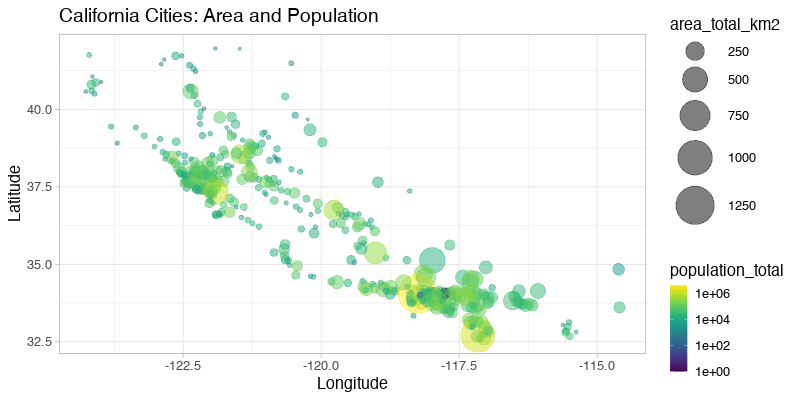

In [112]:
import rpy2.robjects.lib.ggplot2 as gp

viridis = importr('viridis')
class ScaleColorViridis(gp.ScaleColour):
    _constructor = viridis.scale_color_viridis
scale_color_viridis = ScaleColorViridis.new

p = (gp.ggplot(dataf) +
     gp.aes(x=rl('longd'),
            y=rl('latd'),
            color=rl('population_total'),
            size=rl('area_total_km2')) +
     gp.geom_point(alpha=0.5) +
     gp.scale_x_continuous('Longitude') +
     gp.scale_y_continuous('Latitude') +
     gp.scale_size(range=IntVector([1, 18])) +
     scale_color_viridis(trans='log10') +
     gp.ggtitle('California Cities: Area and Population') +
     gp.theme_light(base_size=16))
image_png(p)